## Countercurrent Heat Exchanger

UPWIND DIFFERENCING <br>
Hot Side
$$
        \frac{dH_H^{(j)}}{dt} = \frac{m_H}{A_c \rho_H \Delta z} H_H^{(j-1)} - \frac{m_H}{A_c \rho_H \Delta z} H_H^{(j)}  - \frac{UP}{A_c \rho_H} \left( T_H^{(j)} - T_C^{(j)} \right)    
$$




Cold Side
$$
        \frac{dH_C^{(j)}}{dt} = \frac{m_C}{A_c \rho_C \Delta z} H_C^{(j+1)} - \frac{m_C}{A_c \rho_C \Delta z} H_C^{(j)}  + \frac{UP}{A_c \rho_C} \left( T_H^{(j)} - T_C^{(j)} \right)      
$$



In [205]:
#!pip install celluloid


In [206]:
import scipy, scipy.integrate, scipy.interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.animation import FuncAnimation
from celluloid import Camera
import IPython.display as IPdisplay
from PIL import Image


#%config InlineBackend.figure_format = 'retina'

style.use("classic")

%matplotlib inline

In [207]:
R = 8.314462  # J/K/gmol
global ref_T 
ref_T = 298.16 # K

def H_H(T):
    Cn = [-0.747, 67.96, -37.78]
    H =  R*(Cn[0]*(T - ref_T) + (Cn[1]*1e-3)*(T**2 - ref_T**2)/2 + (Cn[2]*1e-6)*(T**3 - ref_T**3)/3)*(1000/78)
    return H

def H_C(T):
    Cn = [8.712, 1.25e-3, -0.18e-6]    
    H =  R*(Cn[0]*(T - ref_T) + (Cn[1]*1e-3)*(T**2 - ref_T**2)/2 + (Cn[2]*1e-6)*(T**3 - ref_T**3)/3)*(1000/18)
    return H

hotfluid = 'Benzene'
coldfluid = 'Water'

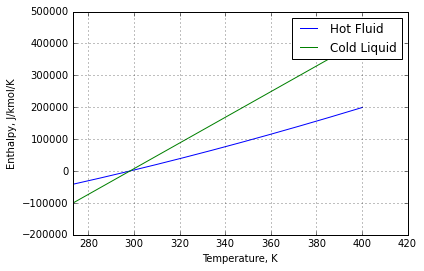

In [208]:
T = np.linspace(273.16, 400.16, 1000)
plt.plot(T, H_H(T), label = 'Hot Fluid')
plt.plot(T, H_C(T), label = 'Cold Liquid')
plt.xlabel('Temperature, K')
plt.ylabel('Enthalpy, J/kmol/K')
plt.legend()
plt.xlim(left = 273.16); #plt.ylim(bottom = 0)
plt.grid(True)

In [209]:
def model(SV, t, heatx):
    n = heatx.n
    
    H_hot = SV[:n]
    H_cold = SV[n:]
    
    T_hot  = heatx.T_H(H_hot)
    T_cold = heatx.T_C(H_cold)
    
    H_hot_in = H_H(heatx.T_hot_in)
    H_cold_in = H_C(heatx.T_cold_in)
    
    rho_hot, rho_cold = heatx.rho_hot, heatx.rho_cold
    AcH, AcC, U, P = heatx.Ac_hot, heatx.Ac_cold, heatx.U, heatx.P
    
    m_hot = heatx.m_hot
    m_cold = heatx.m_cold
    
    delz = heatx.L/n
    
    dH_hotbydt = np.zeros(n)
    dH_coldbydt = np.zeros(n)
    
    dH_hotbydt[1:] = m_hot/(AcH*rho_hot*delz) * H_hot[0:-1] - m_hot/(AcH*rho_hot*delz) * H_hot[1:] - U*P/(AcH*rho_hot)*(T_hot[1:] - T_cold[1:])
    
    dH_coldbydt[:-1] = m_cold/(AcC*rho_cold*delz) * H_cold[1:] - m_cold/(AcC*rho_cold*delz) * H_cold[:-1] + U*P/(AcC*rho_cold)*(T_hot[:-1] - T_cold[:-1])
    
    dH_hotbydt[0] = m_hot/(AcH*rho_hot*delz) * H_hot_in - m_hot/(AcH*rho_hot*delz) * H_hot[0] - U*P/(AcH*rho_hot)*(T_hot[0] - T_cold[0])
    
    dH_coldbydt[-1] = m_cold/(AcC*rho_cold*delz) * H_cold_in - m_cold/(AcC*rho_cold*delz) * H_cold[-1] + U*P/(AcC*rho_cold)*(T_hot[-1] - T_cold[-1])
    
    dH_hotbydt = list(dH_hotbydt)
    dH_coldbydt = list(dH_coldbydt)
    dSV = dH_hotbydt + dH_coldbydt
    return dSV

## Class to Animate Temperature vs Time 


In [210]:
class AnimateTemp :

  def show_anim(self,Time, fluid = True):
    n = self.n
    t = Time
    self.solve(Time)
    sol = self.solution
    Temp_hot = self.T_H(sol[:, : self.n] )
    Temp_cold = self.T_C(sol[:, self.n :] )
    self.delT_in = Temp_hot[-1,0] - Temp_cold[-1,0]
    self.delT_out = Temp_hot[-1,-1] - Temp_cold[-1,-1]
    self.lmtd = (self.delT_in-self.delT_out)/np.log(self.delT_in/self.delT_out)
        
    ispot1, ispot2, ispot3 = int(self.n/3)-1, int(2*self.n/3)-1, int(3*self.n/3)-1
    ind = [ispot1, ispot2, ispot3]
    fig = plt.figure(facecolor='white', figsize=(7, 7))
    plt.suptitle("Temperature vs Time (n = %d)" % n)
    plt.grid(True)
    plt.xlabel('Time, s') ; plt.ylabel('Temperature, K')
    plt.xlim(0, t[-1])
    plt.ylim(0.9 * self.T_cold_in, 1.1 * self.T_hot_in)
    textstr =("Temp Difference (K)\n \n"+ 
                 "@(z=0): %.1f\n" %(self.delT_in)+ 
                 "@(z=%.1f): %.1f\n" %(self.L, self.delT_out)+
                 "LMTD: %.1f" %(self.lmtd))
    props = dict(boxstyle='round', facecolor='gold', alpha=0.5)
    fig.text(0.95, 0.5, textstr, fontsize=10,
    verticalalignment='top', bbox=props);
    
    if fluid :
         plt.annotate(r'$Initial \; Condition $', xy=(0, 1.05*self.T_hot_in))
    else :
         plt.annotate(r'$Initial \; Condition $', xy=(0, 0.95*self.T_cold_in))
    if fluid :
      line1, = plt.plot(0,self.T_hot_in, 'r', label= 'z = '+ str(round(self.L*1/3, 2))+' m' , lw =2 )
      line2, = plt.plot(0,self.T_hot_in, 'b', label= 'z = '+ str(round(self.L*2/3, 2))+' m', lw =2 )
      line3, = plt.plot(0,self.T_hot_in, 'g', label= 'z = '+ str(round(self.L*3/3, 2))+' m', lw =2 )
    else:   
      line1,= plt.plot(0,self.T_cold_in, 'r', label= 'z = '+ str(round(self.L*1/3, 2))+' m', lw =2 )
      line2,= plt.plot(0,self.T_cold_in, 'b', label= 'z = '+ str(round(self.L*2/3, 2))+' m', lw =2 )
      line3,= plt.plot(0,self.T_cold_in, 'g', label= 'z = '+ str(round(self.L*3/3, 2))+' m', lw =2 )
    plt.legend(loc='best', fontsize=5 , prop={"size":15})
    time, temph1, temph2, temph3, tempc1, tempc2, tempc3 = [], [], [] , [], [], [] , []

    def animate_plot(i) :      
        plt.title(r"$t = %d$" % t[i])        
        time.append(t[i]) 
        temph1.append(Temp_hot[i , ispot1]) ; temph2.append(Temp_hot[i , ispot2]) ; temph3.append(Temp_hot[i , ispot3]) 
        tempc1.append(Temp_cold[i , ispot1]) ; tempc2.append(Temp_cold[i , ispot2]) ; tempc3.append(Temp_cold[i , ispot3]) ;
        if fluid:
          line1.set_data(time, temph1 ) ; line2.set_data(time, temph2 ) ; line3.set_data(time, temph3 )
        else:
          line1.set_data(time, tempc1 ) ; line2.set_data(time, tempc2 ) ; line3.set_data(time, tempc3 )
        
        return line1, line2, line3
    if fluid:
      name = 'Counter_current_heatex_Hot_side_n_' + str(n)
    else:
      name = 'Counter_current_heatex_Cold_side_n_' + str(n)  
    animation = FuncAnimation(fig, animate_plot , frames=n, interval=200 );
    animation.save(name+'.gif', writer='pillow', fps=6 )
        

## Class to Animate Temperature vs Position

In [211]:
class AnimateSpace:
  def show_anim_space(self,Time):
    t = Time
    n = self.n
    self.solve(t)
    sol = self.solution
    Temp_hot = self.T_H(sol[:, : self.n] )
    Temp_cold = self.T_C(sol[:, self.n :] )
    fig = plt.figure(facecolor='white', figsize=(7, 7))
    plt.suptitle("Temperature vs Length of Heat Exchanger (n = %d)" % n)
    
    instackh = np.ones((1,n)) * self.T_hot_in ; instackc = np.ones((1,n)) * self.T_cold_in
    instack = np.vstack((instackh, instackc))
    line = plt.pcolormesh(instack)
    plt.annotate(r'$Input \; Hot \; Fluid $', xy=(0, 0.5))
    plt.annotate(r'$Input \; Cold \; Fluid $', xy=(0.7*n, 1.5))
    
    plt.colorbar()
    time, temph, tempc = [], [], []
    
    def animated_plot(i):  
        i = int(i)
        plt.title(r"$t = %d$" % self.t[i])
        time.append(t[i]) 
        temph.append(Temp_hot[i]) ; tempc.append(Temp_cold[i])
        stack = np.vstack((Temp_hot[i], Temp_cold[i]))
        line.set_array(stack.ravel()) 
        
        return line 
     
    name = 'Counter_current_temp_position_n_' 
    animation = FuncAnimation(fig, animated_plot, frames=n, interval=200, blit = False);
    animation.save(name + str(n) + '.gif', writer='pillow', fps=5)
    

## Class To perform operations :

In [212]:
class CounterCurrentHex(AnimateTemp, AnimateSpace):
    def __init__(self):
        self.L = 1.0
        self.n = 100
        
        self.m_hot = 1.0 #kg/s
        self.m_cold = 0.5 #kg/s
        
        self.rho_hot = 876.0 #kg/m3
        self.rho_cold = 1000.0 #kg/m3
        
        self.Ac_hot = np.pi/4*0.1**2
        self.Ac_cold = np.pi/4*0.1**2
        
        self.U = 400.0 #W/m2K
        
        self.P = np.pi * 0.1
        
        self.T_hot_in = 473.16 #K
        self.T_cold_in = 300.0 #K
    
    def initialize(self):
        T = np.linspace(self.T_cold_in, self.T_hot_in, 1000)
        H_hot = H_H(T)
        H_cold = H_C(T)
        self.T_H = scipy.interpolate.UnivariateSpline(H_hot, T, k=1, s=0)
        self.T_C = scipy.interpolate.UnivariateSpline(H_cold, T, k=1, s=0)
    
    def solve(self, t):
        
        Tini =np.concatenate((np.ones(self.n)*self.T_hot_in,np.ones(self.n)*self.T_cold_in))  #np.ones(self.n*2)*self.T_cold_in # 
        SV0 = np.zeros(self.n*2)
        SV0[:self.n] = H_H(Tini[:self.n])
        SV0[self.n:] = H_C(Tini[self.n:])
        
        self.initialize()
        
        self.solution = scipy.integrate.odeint(
                                                model,
                                                SV0,
                                                t,
                                                args=(self,)
        )
        
        delz = self.L/self.n
        pos = [(i+0.5)*delz for i in range(self.n)]
        
        self.t = t
        self.pos = pos

## ***Plotting Results :***
n = 50

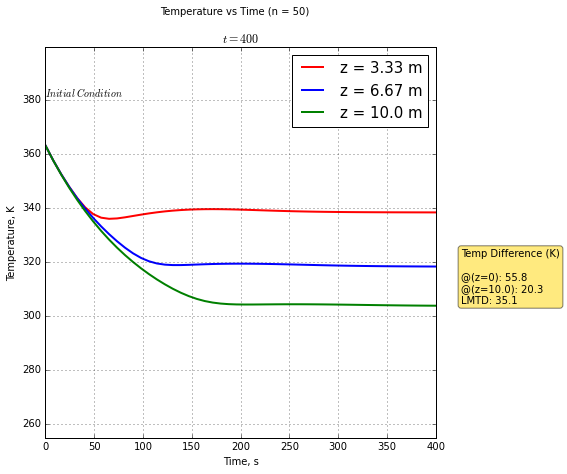

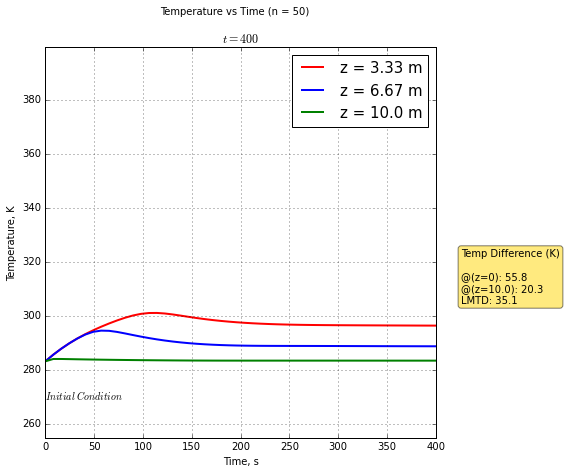

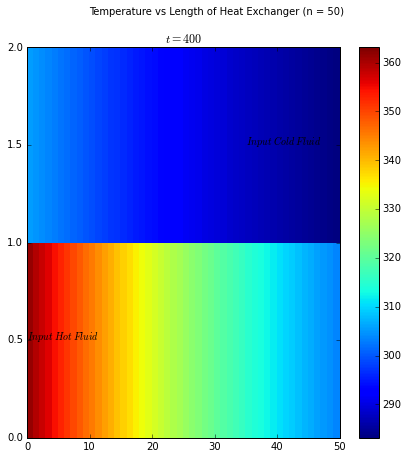

In [213]:
### n = 50, Hot and Cold Side
heatx = CounterCurrentHex()
heatx.L = 10
heatx.T_hot_in = 363.16 #K
heatx.T_cold_in = 283.16 #K
heatx.n = 50 
heatx.m_hot = 0.4 #kg/s
heatx.m_cold = 0.5 #kg/s
Time = np.linspace(0, 400, heatx.n)
heatx.show_anim(Time)
heatx.show_anim(Time, fluid = False)
heatx.show_anim_space(Time)
#Image.open('animation.gif')      # Incase this code is run in jupyter
#IPdisplay.Image(url='animation.gif')

In [214]:
#from google.colab import files
#files.download( "Counter_current_heatex_Hot_side_n_50.gif" ) 
#files.download( "Counter_current_heatex_Cold_side_n_50.gif" )   
#files.download( "Counter_current_temp_position_n_50.gif" )  
Image.open('Counter_current_heatex_Hot_side_n_50.gif')      # Incase this code is run in jupyter
IPdisplay.Image(url='Counter_current_heatex_Hot_side_n_50.gif')



In [215]:
Image.open('Counter_current_heatex_Cold_side_n_50.gif')      # Incase this code is run in jupyter
IPdisplay.Image(url='Counter_current_heatex_Cold_side_n_50.gif')

In [216]:
Image.open('Counter_current_temp_position_n_50.gif')      # Incase this code is run in jupyter
IPdisplay.Image(url='Counter_current_temp_position_n_50.gif')

n = 100 

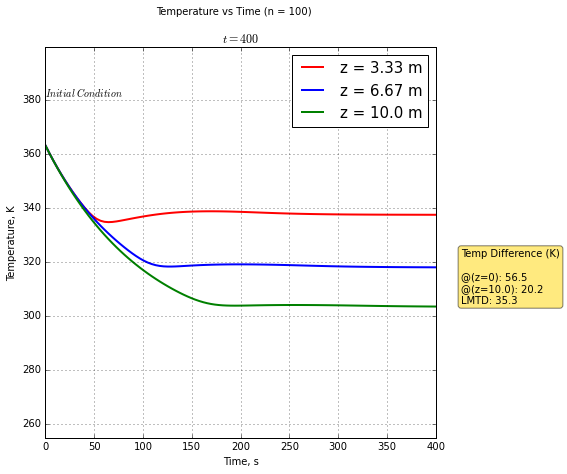

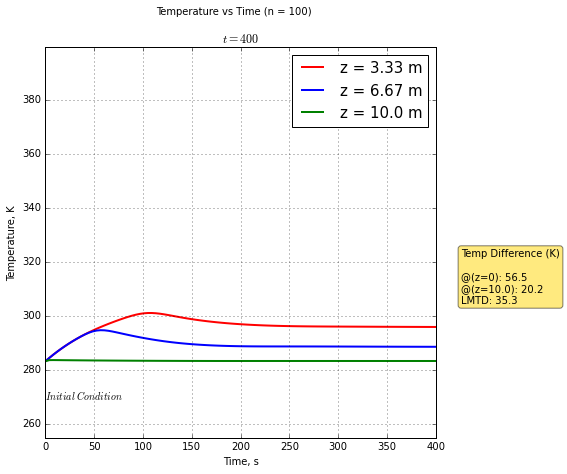

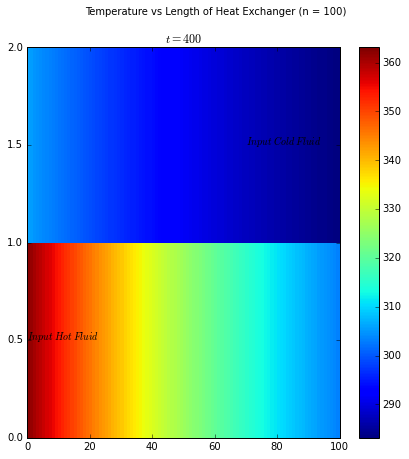

In [217]:
### n = 100, Hot and Cold Side
heatx = CounterCurrentHex()
heatx.L = 10
heatx.T_hot_in = 363.16 #K
heatx.T_cold_in = 283.16 #K
heatx.n = 100
heatx.m_hot = 0.4 #kg/s
heatx.m_cold = 0.5 #kg/s
Time = np.linspace(0, 400, heatx.n)
heatx.show_anim(Time) 
heatx.show_anim(Time, fluid = False)
heatx.show_anim_space(Time)
#Image.open('animation.gif')      # Incase this code is run in jupyter
#IPdisplay.Image(url='animation.gif')

In [218]:
#files.download( "Counter_current_heatex_Hot_side_n_100.gif" ) 
#files.download( "Counter_current_heatex_Cold_side_n_100.gif" )  
#files.download( "Counter_current_temp_position_n_100.gif" )  
Image.open('Counter_current_heatex_Hot_side_n_100.gif')      # Incase this code is run in jupyter
IPdisplay.Image(url='Counter_current_heatex_Hot_side_n_100.gif')



In [219]:
Image.open('Counter_current_heatex_Cold_side_n_100.gif')      # Incase this code is run in jupyter
IPdisplay.Image(url='Counter_current_heatex_Cold_side_n_100.gif')

In [220]:
Image.open('Counter_current_temp_position_n_100.gif')      # Incase this code is run in jupyter
IPdisplay.Image(url='Counter_current_temp_position_n_100.gif')

n = 5

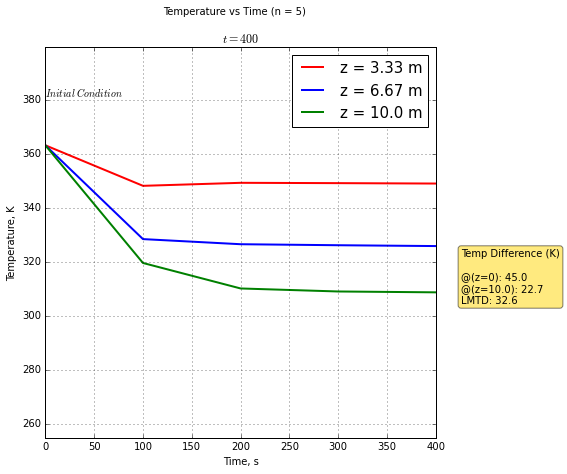

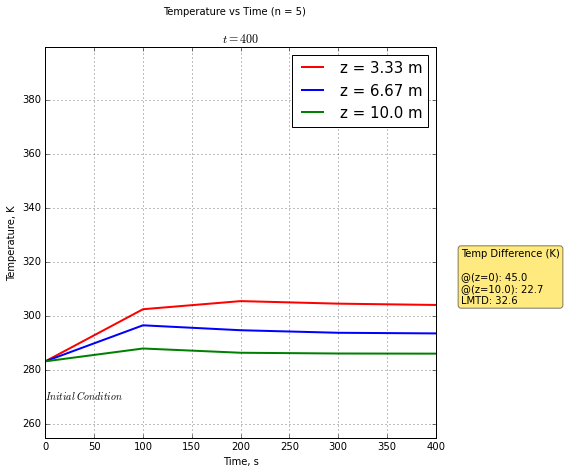

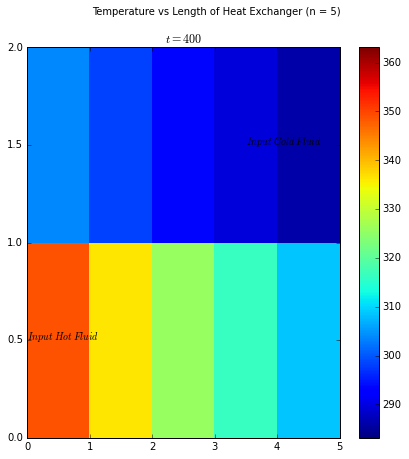

In [221]:
### n = 5, Hot and Cold Side
heatx = CounterCurrentHex()
heatx.L = 10
heatx.T_hot_in = 363.16 #K
heatx.T_cold_in = 283.16 #K
heatx.n = 5
heatx.m_hot = 0.4 #kg/s
heatx.m_cold = 0.5 #kg/s
Time = np.linspace(0, 400, heatx.n)
heatx.show_anim(Time) 
heatx.show_anim(Time, fluid = False)
heatx.show_anim_space(Time)
#Image.open('animation.gif')      # Incase this code is run in jupyter
#IPdisplay.Image(url='animation.gif')

In [222]:
#files.download( "Counter_current_heatex_Hot_side_n_5.gif" ) 
#files.download( "Counter_current_heatex_Cold_side_n_5.gif" )     
#files.download( "Counter_current_temp_position_n_5.gif" )  
Image.open('Counter_current_heatex_Hot_side_n_5.gif')      # Incase this code is run in jupyter
IPdisplay.Image(url='Counter_current_heatex_Hot_side_n_5.gif')



In [223]:
Image.open('Counter_current_heatex_Cold_side_n_5.gif')      # Incase this code is run in jupyter
IPdisplay.Image(url='Counter_current_heatex_Cold_side_n_5.gif')

In [224]:
Image.open('Counter_current_temp_position_n_5.gif')      # Incase this code is run in jupyter
IPdisplay.Image(url='Counter_current_temp_position_n_5.gif')